written by: Jana Vihs, vihsjana@student.hu-berlin.de, 604930
# Dear Jupyter Notebook Reader

fancy, seeing you here. If you're planning on having a nice holiday in London soon, you came to the right place. 
Before we guide you through on how to use our Airbnb Price Predictor, we would like to explain a few details of the experimental design, but don't you worry that won't take long! After this only have to type one command into your terminal and yo'll get the predicted price of your desired airbnb. 

If you like to know how this works in detail, stay tuned and read this  Jupyter Notebook till the end.

Let's start!


## A Word on the Experimental Design 

This Jupyter Notebook builds the core of the project and is intended to provide a common thread regarding data analysis, feature engineering and selection as well as model selection and evaluation of the final method. Nevertheless the main goal is to build a pipeline using .dvc in order to recieve price  predictions for an airbnb in London, United Kingdom [^1].

### Tools

As we are using a lot of new tools to develop our pipeline let us look at them a little more closely.

#### Docker

The whole project comes with a Dockerfile, which defines our project environment. You can use it but you don't have to. If you're a Docker Newbie checkout the following link https://docs.docker.com/get-started/ and make sure Docker is installed. 
Then run the following commands in your terminal to build a docker image and run the application inside a container.


1. *docker build . -t airbnb* 
2. *docker run -it --name airbnb -v $(pwd):/root/ airbnb bash*

Then you should be inside the docker container. To make sure all necessary dependencies are installed please run *pip install -r requirements.txt* inside the terminal of your docker container.

If you don't want to use Docker that is totally fine, just run *pip install -r requirements.txt* to have all the packages available.

#### .DVC



https://dvc.org/

#### Project Architecture

gives an overview of the structure of this project

    ├── .gitlab-ci.yml: Defines the pipeline for CI.
    ├── Dockerfile: Defines the environment.
    ├── README.md: Top level documentation for developers.
    ├── data
    │ ├── external: Data from third party sources. 
    │ ├── interim: Intermediate data that has been transformed.
    │ ├── canonical: Final data sets for modeling.
    │ └── raw: The original, immutable data dump.
    ├── dvc.yaml: Defines the data pipelines.
    ├── models: Trained and serialized models, model predictions, or model summaries.
    │
    ├── notebooks: Jupyter notebook.
    ├── references: Data dictionaries, manuals and other explanatory materials.
    │
    ├── reports: Generated analysis as pdf etc.
    ├── requirements.txt: Requirements file python dependencies. 
    ├── setup.py: Make this project pip installable.
    └── src: Source code for use in this project.
        ├── __init__.py: Makes `src` a python module
        ├── data: Scripts to download or generate data. Scripts to turn raw data into features for modeling.
        ├── features: Scripts to turn raw data into features for modeling.
        ├── models: Scripts for training and scoring.
        └── visualization: Scripts to create exploratory and results oriented visualizations.


[^1]: <small> Packaging (installation of the package via pip) of the module is omitted, but is theoretically possible </small>.

As said before if you want to know how everything works in detail i hope you'll enjoy the following Notebook with the title:

# The Airbnb Price Predictor - London Area

### Table of Contents
- Introduction
    - Meta Information
- Data Preprocessing
    - Missing Values        
- Explorative Data Analysis
    - Numeric Features about the Airbnb 
    - Numeric Features about the Host
    - Text Data 
        - Descriptions 
        - Reviews
    - Images 
- Feature Engineering 
    - Distance to City Center
    - Host since in years
    - Text Data 
         - Description Text Length
         - LDA - Latent Dirichlet Allocation
         - Sentiment Analysis of review data
    - Images 
        - Colors and Brightness
    - Hot Encoded Features     
- Feature Selection
    - Feature Importance 
    - Grid Search
- Benchmark Models
    - Multivariate Linear Regression
    - Neural Networks  
- Model Evaluation
- Final Method
    - Hyperparameter Tuning
- Conclusion and Outlook
- References 

# Introduction

Airbnb, is a globally known peer-to-peer platform for short-term rental of housing accommodation.
Whats the problem


In [70]:
# import all necessary packages 
# Standards 
import pandas as pd 
import numpy as np
import os 
import math
import sys

# NLP
import spacy
from collections import Counter

# Visulaizations
import seaborn as sns
import folium
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from wordcloud import WordCloud
%matplotlib inline

import datetime
import warnings
warnings.filterwarnings('ignore')

# Translator
from google_trans_new import google_translator



In [2]:
# change python path too include modules that i wrote myself
sys.path.append(os.path.dirname('../src'))
from src.features.preprocess.Processor import Processor
from src.features.preprocess.Textprocessor import TextProcessor

In [3]:
# load data set 
train = pd.read_csv('../data/raw/train.csv', index_col='listing_id')
test = pd.read_csv('../data/raw/test.csv', index_col='listing_id')
reviews = pd.read_csv('../data/raw/reviews.csv', index_col='listing_id')

# Meta Information 

The designated data set is available on Kaggle https://www.kaggle.com/c/adams2021/data and contains the following features


<!DOCTYPE html>
<html>
   <head>
      <style>
         table, td, th, tr {
            border: 1px solid black;
            width: 300px;  300px; 300px;
         }
      </style>
   </head>
   <body>
      <table>
         <tr>
            <th>Feature</th>
            <th>Description</th>
            <th>Data Type</th>
         </tr>
         <tr>
            <td style="text-align:center">name</td>
            <td style="text-align:center">the actual name of the advertisment</td>
            <td style="text-align:center">text data</td>
         </tr>
         <tr>
            <td style="text-align:center">summary</td>
            <td style="text-align:center">description of the airbnb</td>
            <td style="text-align:center">text data</td>
         </tr>
         <tr>
            <td style="text-align:center">space</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">text data</td>
         </tr>
          <tr>
            <td style="text-align:center">description</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">text data</td>
         </tr>
          <tr>
            <td style="text-align:center">experiences_offered</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">text data</td>
         </tr>
          <tr>
            <td style="text-align:center">neigbhourhood_overview</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">text data</td>
         </tr>
          <tr>
            <td style="text-align:center">transit</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">text data</td>
         </tr>
          <tr>
            <td style="text-align:center">house_rules</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">text data</td>
         </tr>
          <tr>
            <td style="text-align:center">picture_url</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">string</td>
         </tr>
          <tr>
            <td style="text-align:center">host_id</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">text data</td>
         </tr>
          <tr>
            <td style="text-align:center">host_since</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">date</td>
         </tr>
          <tr>
            <td style="text-align:center">host_response_time</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">text data</td>
         </tr>
          <tr>
            <td style="text-align:center">host_response_rate</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">text data</td>
         </tr>
          <tr>
            <td style="text-align:center">host_is_superhost</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">boolean</td>
         </tr>
          <tr>
            <td style="text-align:center">host_total_listings_count</td>
            <td style="text-align:center">The number of ads a host has on the domain airbnb.com for London</td>
            <td style="text-align:center">numeric</td>
         </tr>
          <tr>
            <td style="text-align:center">host_has_profile_pic</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">boolean</td>
         </tr>
          <tr>
            <td style="text-align:center">host_identity_verified</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">boolean</td>
         </tr>
          <tr>
            <td style="text-align:center">neighbourhood</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">text data</td>
         </tr>
          <tr>
            <td style="text-align:center">neighbourhood_cleansed</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">text data</td>
         </tr>
          <tr>
            <td style="text-align:center">zipcode</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">text data</td>
         </tr>
          <tr>
            <td style="text-align:center">latitude</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">numeric</td>
         </tr>
          <tr>
            <td style="text-align:center">longitude</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">numeric</td>
         </tr>
          <tr>
            <td style="text-align:center">property_type</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">categoric</td>
         </tr>
          <tr>
            <td style="text-align:center">room_type</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">text data</td>
         </tr>
          <tr>
            <td style="text-align:center">accommodates</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">text data</td>
         </tr>
          <tr>
            <td style="text-align:center">bathrooms</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">numeric</td>
         </tr>
          <tr>
            <td style="text-align:center">bedrooms</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">numeric</td>
         </tr>
          <tr>
            <td style="text-align:center">beds</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">numeric</td>
         </tr>
          <tr>
            <td style="text-align:center">bed_type</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">text data</td>
         </tr>
          <tr>
            <td style="text-align:center">amenities</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">numeric</td>
         </tr>
          <tr>
            <td style="text-align:center">guests_included</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">text data</td>
         </tr>
          <tr>
            <td style="text-align:center">review_scores_rating</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">text data</td>
         </tr> <tr>
            <td style="text-align:center">review_scores_accuracy</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">text data</td>
         </tr>
         </tr> <tr>
            <td style="text-align:center">review_scores_cleanliness</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">text data</td>
         </tr>
         </tr> <tr>
            <td style="text-align:center">review_scores_checkin</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">text data</td>
         </tr>
         </tr> <tr>
            <td style="text-align:center">review_scores_communication</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">text data</td>
         </tr>
         </tr> <tr>
            <td style="text-align:center">review_scores_location</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">text data</td>
         </tr>
         </tr> <tr>
            <td style="text-align:center">review_scores_value</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">text data</td>
         </tr>
         </tr> <tr>
            <td style="text-align:center">cancellation_policy</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">text data</td>
         </tr>
         </tr> <tr>
            <td style="text-align:center">reviews_per_month</td>
            <td style="text-align:center"></td>
            <td style="text-align:center">text data</td>
         </tr>
         </tr> <tr>
            <td style="text-align:center">price</td>
            <td style="text-align:center"><b>Target variable;</b> the price of the listed airbnb</td>
            <td style="text-align:center">numeric</td>
         </tr>
      </table>
   </body>
</html>

         
                         
                                                

The review data set contains the following :

<!DOCTYPE html>
<html>
   <head>
      <style>
         table, td, th, tr {
            border: 1px solid black;
            width: 300px;
         }
      </style>
   </head>
   <body>
      <table>
         <tr>
            <th>Feature</th>
            <th>Description</th>
            <th>Data Type</th>
         </tr>
         <tr>
            <td style="text-align:center">reviwer_id</td>
            <td style="text-align:center">the actual name of the advertisment</td>
            <td style="text-align:center">text data</td>
         </tr>
         <tr>
            <td style="text-align:center">comments</td>
            <td style="text-align:center">the actual name of the advertisment</td>
            <td style="text-align:center">text data</td>
         </tr>
         <tr>
            <td style="text-align:center">review_id</td>
            <td style="text-align:center">the actual name of the advertisment</td>
            <td style="text-align:center">text data</td>
         </tr>
              </table>
   </body>
</html>




In [4]:
print('Our train data consists of {}'.format(train.shape[0]) + ' rows and {}'.format(train.shape[1]) + ' columns, while our test data contains {}'.format(test.shape[0]) + ' rows and {}'.format(test.shape[1]) + ' columns.')
print('The additional data set reviews consist of {}'.format(reviews.shape[0]) + ' rows and {}'.format(reviews.shape[1]) + ' columns')

Our train data consists of 55284 rows and 41 columns, while our test data contains 29769 rows and 40 columns.
The additional data set reviews consist of 1540778 rows and 3 columns


# Data Preprocessing

In [4]:
#  change data types because of memory reasons
processor = Processor()
train = processor.change_data_types(train)
test = processor.change_data_types(test)
reviews = processor.change_data_types(reviews)

## Missing values

As the following table shows we have a few missing values in our data. 

In [5]:
# Missing values in test data
test.isnull().sum()

name                              10
summary                         1577
space                           9057
description                      943
experiences_offered                0
neighborhood_overview          10551
transit                        10672
house_rules                    12580
picture_url                        0
host_id                            0
host_since                        65
host_response_time              9572
host_response_rate              9572
host_is_superhost                  0
host_total_listings_count         65
host_has_profile_pic               0
host_identity_verified             0
neighbourhood                     86
neighbourhood_cleansed             0
zipcode                          635
latitude                           0
longitude                          0
property_type                      0
room_type                          0
accommodates                       0
bathrooms                         50
bedrooms                          29
b

In [6]:
# Missing values  in train data 
train.isnull().sum()

name                              14
summary                         2954
space                          16881
description                     1726
experiences_offered                0
neighborhood_overview          19506
transit                        19807
house_rules                    23378
picture_url                        0
host_id                            0
host_since                       111
host_response_time             17802
host_response_rate             17802
host_is_superhost                  0
host_total_listings_count        111
host_has_profile_pic               0
host_identity_verified             0
neighbourhood                    147
neighbourhood_cleansed             0
zipcode                         1272
latitude                           0
longitude                          0
property_type                      0
room_type                          0
accommodates                       0
bathrooms                         70
bedrooms                          62
b

In [8]:
# Missing values reviews
reviews.isnull().sum()

reviewer_id      0
comments       691
review_id        0
dtype: int64

For some features we will just fill them up with a one because their has to be a bathroom at least one bedroom and one bed even if the bedroom is a living room and the bed a couch, but why then would you need an Airbnb, right ? With the zipcodes we use geopy and get the missing values from latitude and longitude, using our Processor in Processory.py. During our analysis and filling up the missing values of the zipcodes with the ones that we gpot from geopy we found out that exactly 14 zipcodes in the training set coulnd not be found and ten for the test set. Those are probably those which are shitty. Treating them as one group of missing values each. Price in train data is almost for all 49.0

In [7]:
train_old = train.copy()
test_old = test.copy()
train = processor.NaNs(train)
test = processor.NaNs(test)

In [10]:
# save interims 
train.to_csv('/root/data/interim/train/train_0.csv')
test.to_csv('/root/data/interim/test/test_0.csv')

In [11]:
# 14 and 10 in train and test which are complety shitty and lost
train.isnull().sum()

name                              14
summary                         2954
space                          16881
description                     1726
experiences_offered                0
neighborhood_overview          19506
transit                        19807
house_rules                    23378
picture_url                        0
host_id                            0
host_since                       111
host_response_time             17802
host_response_rate             17802
host_is_superhost                  0
host_total_listings_count        111
host_has_profile_pic               0
host_identity_verified             0
neighbourhood                    147
neighbourhood_cleansed             0
zipcode                           14
latitude                           0
longitude                          0
property_type                      0
room_type                          0
accommodates                       0
bathrooms                          0
bedrooms                           0
b

In [90]:
train_old[['host_response_time','host_response_rate', 'host_since', 'host_total_listings_count']]

,host_response_time,host_response_rate,host_since,host_total_listings_count
listing_id,,,,
9Q1RD6H7IO,within an hour,100%,2012-04-18,1.0
6XDPZPGLSR,within a few hours,100%,2014-05-29,1.0
SND9OPN6IY,within an hour,100%,2019-06-28,2.0
SE3B7BXN9G,within a few hours,100%,2012-08-24,1.0
E0C82VK0VF,within an hour,100%,2016-09-09,2.0
...,...,...,...,...
HSY40NEHOI,NaN,NaN,2015-02-25,2.0
XZXB1NS63Y,NaN,NaN,2018-08-05,1.0
Z2T8G6D82D,within an hour,100%,2017-07-01,4.0


In [12]:
# Merge reviews on train using listing_id
trainReview = train.merge(reviews, on='listing_id')

In [22]:
# multiple reviews for one airbnb /host. makes sense
len(trainReview)

1000572

In [12]:
trainReview[['comments', 'review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',	'review_scores_communication',	'review_scores_location',	'review_scores_value', 'reviews_per_month']].head(10)

,comments,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
listing_id,,,,,,,,,
9Q1RD6H7IO,The best airbnb address on my Thames Path walk...,95.0,10.0,10.0,10.0,10.0,10.0,10.0,2.37
9Q1RD6H7IO,very satisfied of my stay with Richard. He was...,95.0,10.0,10.0,10.0,10.0,10.0,10.0,2.37
9Q1RD6H7IO,"As I was staying again at Richard’s home, it w...",95.0,10.0,10.0,10.0,10.0,10.0,10.0,2.37
9Q1RD6H7IO,"very pleasant, very clean room. Just what I n...",95.0,10.0,10.0,10.0,10.0,10.0,10.0,2.37
9Q1RD6H7IO,The room was very comfortable and Richard was...,95.0,10.0,10.0,10.0,10.0,10.0,10.0,2.37
9Q1RD6H7IO,Richard was a lovely host! But we had a couple...,95.0,10.0,10.0,10.0,10.0,10.0,10.0,2.37
9Q1RD6H7IO,Richard's flat is extremely well located and G...,95.0,10.0,10.0,10.0,10.0,10.0,10.0,2.37
9Q1RD6H7IO,I had a very comfortable stay in Richard's cos...,95.0,10.0,10.0,10.0,10.0,10.0,10.0,2.37
9Q1RD6H7IO,Thanks for another comfortable stay Richard.,95.0,10.0,10.0,10.0,10.0,10.0,10.0,2.37


In order to get a better grip of our data, we split our traing data into different categories, to make analysation simpler.
Dataframe host which contain infos about the host of the airbnb, the information in airbnb itself and the information about the reviews.

In [13]:
# lets split our data set in 3 different categories to make analyse simpler
host, airbnb, review_scores = Processor().split_df(train)

As we will consider some features later during our analysis will narrow our dataframes down to specfic columns.

In [14]:
airbnb = airbnb.drop(['picture_url', 'longitude', 'latitude', 'zipcode', 'neighbourhood'], axis=1)

In [15]:
review_scores.describe()

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
count,41869.000000,41836.000000,41842.000000,41801.000000,41838.000000,41804.000000,41804.000000,42904.000000
mean,92.533043,9.502869,9.261484,9.622043,9.652851,9.541623,9.262846,1.164464
std,10.030621,0.982464,1.138548,0.894931,0.873805,0.810408,1.033351,1.353819
min,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.010000
25%,90.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,0.240000
50%,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,0.730000
75%,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.570000
max,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,22.040001


# Explorative Data Analysis

In [16]:
airbnb.describe()

,accommodates,bathrooms,bedrooms,beds,price,guests_included
count,55284.000000,55284.000000,55284.000000,55284.000000,55284.000000,55284.000000
mean,3.131756,1.283491,1.373453,1.707293,104.308754,1.574832
std,1.930209,0.566288,0.859057,1.222371,83.740410,1.263427
min,1.000000,0.000000,0.000000,0.000000,10.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,45.000000,1.000000
50%,2.000000,1.000000,1.000000,1.000000,80.000000,1.000000
75%,4.000000,1.500000,2.000000,2.000000,130.000000,2.000000
max,16.000000,11.000000,19.000000,21.000000,500.000000,46.000000


#### Price Distribution


In [17]:
# Price distribution 

### Correlation Plot
Regarding the features , makes sense 

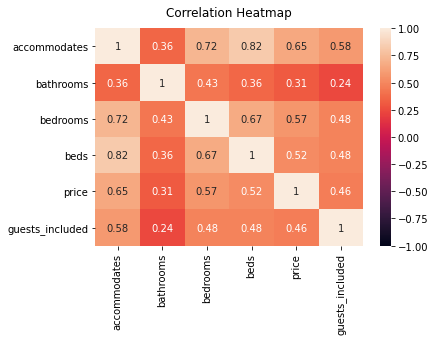

In [18]:
# Correlation plot
corr = trainReview[['accommodates', 'bathrooms', 'bedrooms','beds', 'price','guests_included']].corr()
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [19]:
# Create map
lonlat = list(zip(train.longitude, train.latitude))
mapit = folium.Map( location=[52.667989, -1.464582], zoom_start=6 )
for coord in lonlat:
    folium.Marker( location=[ coord[0], coord[1] ], fill_color='#43d9de', radius=8 ).add_to( mapit )

mapit.save( 'map.html')

### Text Data 


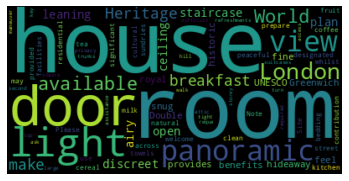

In [74]:

wordcloud = WordCloud().generate(description_2)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
In order to analyze our text data we will use **spacy** https://spacy.io/.

# Feature Engineering 



## Zipcode, Longitude and Lattitude
If you are analysing a bigger city that has multiple locations that are considered desirable, you can also run this code as many times as needed with different geographical points. (Don’t forget to change the column names so you don’t overwrite the previous point!).
For example, there is a financial district close to the Amsterdam Zuid station that could be equally (or even more) relevant to working tenants than living close to the city center. Measuring these various scenarios is more important if you are using methods similar to multiple linear regressions rather than machine-learning statistical algorithms because they are inherently better at recognising non-linear relationships and clusters. For this reason, I won’t include it in this analysis but it is an interesting factor to weight in depending on the statistical method being used. As Airbnb is mainly used fo holiday i would say hence we chose a pretty touristic place
**Distance to City Center**. We have chosen the Picadally Circus as city center, but using other coordinates might also be possible

<img src="/root/data/external/londonpiccadillycircus.jpg" alt="Piccadally Circus" title="" />




## Host_Since

Since we have our feature *host_since* in our dataframe we can calculate how long the host is acutally registered at the platform 

**Host History**

## Images

Thanks to the feature *picture_url* we are able to crawl all the images, so we actually are able to see how the Airbnb looks like.
The code can be found in **/root/src/ingest/ImageCrawler.py** and the actual images will be stored in **/root/data/images/** in the designated directories regarding test and train data. The images themselves will be processed using our **ImageProcessor**. To keep our scope narrow, we will pull four values from the image that may be of value: the brightness and the RGB values, hence the number of red, blue and green pixels. 

** Why could this be important ? **

Taking a step back, we can think of a few things in the image that may impact the price:

    - Are the floors carpet or hardwood?
    - Are the walls painted or wallpaper? Paintings or posters?
    - Does the host have plants? Are they alive and healthy?
    - Is the picture well-lit and inviting?




## Reviews

The reviews and the text data in general contains valuable information so we dedicated a whole chapter to it.


## Yelp Data

As we are going for holiday to London we of course want to find out about all the restaurants. want to stay close to the busiest places to actually see London, so being close to the restaurants and markets and shop might have an impact to the price of airbnb
To find that out we scrape data using the Yelp API https://www.yelp.com/developers

# Sentiment/ Text  Analysis
Reviews contain reviews in different languages. spanish, french, from asian background. Thumpsup
For example, if we are working with product reviews sentiment analysis data where we have to identify each review whether it is positive or negative. People may write the emoji in a review to express the feeling towards the product how much he/she is satisfied with the product. In that case, we may lose valuable information if we remove the emojis. In this case, a better approach is to convert emoji to word format so that it preserves the emoji information.


1.Step : Clean Data unnecessary \r \n etc.

2.Step : emojis

3.Step : Mulitlangues

In [20]:
# Initialize our Textprocessor and Translator from google
textprocessor = TextProcessor()
translator = google_translator()  
reviews.comments[5]

'This is a great place to stay! Adriano and Valerio are wonderful hosts, super friendly, welcoming, and respectful. Valerio is the perfect guy to talk to and make you feel welcome in a warm home environment.\r\nThe bedroom is very comfortable, my mom and I stayed with them for a few days and felt like home. The bathroom and flat were very clean :) The location has close access to the tube station and many buses, food stores, and ATMs.\r\nValerio kindly prepared coffee and set breakfast for us every day :)\r\nAdriano is very knowledgeable of the city and places you should visit and ways to get there. He advised us on places to go, sights, and everything.\r\nThanks for being so nice guys! If I ever go back to London this will definitely be the place I hope to stay.'

In [21]:
# Step 1
textprocessor.clean(reviews.comments[5])

'this is a great place to stay! adriano and valerio are wonderful hosts, super friendly, welcoming, and respectful. valerio is the perfect guy to talk to and make you feel welcome in a warm home environment.the bedroom is very comfortable, my mom and i stayed with them for a few days and felt like home. the bathroom and flat were very clean :) the location has close access to the tube station and many buses, food stores, and atms.valerio kindly prepared coffee and set breakfast for us every day :)adriano is very knowledgeable of the city and places you should visit and ways to get there. he advised us on places to go, sights, and everything.thanks for being so nice guys! if i ever go back to london this will definitely be the place i hope to stay.'

In [22]:
# Step 2
text = textprocessor.clean(reviews.comments[1455])


In [23]:
translator.translate(text)

"Hello, we have spent three great days in London, at ELISA's house! She is lovely, she and she was a stay in London very, very nice! I highly recommend it, if we return to London I would like to go home from Elisa! Thank you very muchBesos.lidia "

In [24]:

thumps_up = reviews[reviews.comments.str.contains('👍',na=False,regex=False)==True]

In [25]:
asia = reviews[reviews.comments.str.contains('ﾛﾝﾄﾞﾝ',na=False,regex=False)==True]

In [26]:
thumps_up.comments[0]

'👍'

In [27]:
textprocessor.convert_emojis_to_word(thumps_up.comments[0])

'thumbs_up'

In [28]:
text = asia.comments[2]

In [29]:
translator.translate(text)

"The host house is located in a quiet upscale residential area just a short distance from London's urban areas. There are several train stations around the house, making it easy to get to London. The interior of the house was very beautiful and cozy like a home . The Host and Her Daughter Were Also Very Kind and Friendly. IF I Visit London Again, I Would Like to Stay Again.  London's urban area is located a little away, and there is a host house in a quiet luxury residential area. There are several stations around the house, and you can easily go to the urban area The house interior was very beautiful and cozy. The host and his daughter were also very kind and kind. If you visit London, I would like to stay again. If you travel to London If you stay at a person's house, everything will work. "

In [14]:
nlp = spacy.load("en_core_web_sm")

In [23]:
description_2 = trainReview['description'][2]

In [24]:
doc = nlp(description_2)

In [51]:
tokens = [token for token in doc ]

In [59]:
# remove stopwords
filtered = [token for token in tokens if not token.is_stop]
# remove puntuations
filtered = [token for token in filtered if not token.is_punct]
# remove white spaces 
filtered = [token for token in filtered if not token.is_space ]
# lemmatize and turn it to lowercase
lemmas = [token.lemma_.strip().lower() for token in filtered]

In [65]:
word_freq = Counter(lemmas)
 # 5 commonly occurring words with their frequencies
common_words = word_freq.most_common(5)
print (common_words)


[('room', 3), ('house', 3), ('door', 2), ('light', 2), ('provide', 2)]


In [66]:
# Unique words
unique_words = [lemmas for (lemma, freq) in word_freq.items() if freq == 1]
print (unique_words)

', 'house', 'peaceful', 'residential', 'street', 'panoramic', 'view', 'london', 'note', 'clean', 'bedding', 'towel', 'provide', 'whilst', 'prepare', 'breakfast', 'welcome', 'use', 'kitchen', 'facility', 'sundrie', 'like', 'cereal', 'fruit', 'milk', 'tea', 'coffee', 'breakfast', 'light', 'refreshment', 'walk', 'house', 'hill', 'attic', 'room', 'second', 'storey', 'privacy', 'door', 'stair', 'tight', 'turn', 'make', 'trunk', 'large', 'suitcase', 'difficult', 'maneuver', 'ask', 'assistance', 'require', 'key', 'access', 'house', 'available', 'reque'], ['room', 'door', 'discreet', 'staircase', 'light', 'airy', 'open', 'plan', 'lean', 'ceiling', 'provide', 'snug', 'hideaway', 'feel', 'benefit', 'fine', 'panoramic', 'view', 'london', 'double', 'room', 'available', 'historic', 'royal', 'greenwich', 'unesco', 'designate', 'world', 'heritage', 'site', 'significant', 'contribution', 'cultural', 'natural', 'heritage', 'world', 'house', 'peaceful', 'residential', 'street', 'panoramic', 'view', 'lon

In [60]:
lemmas

['room',
 'door',
 'discreet',
 'staircase',
 'light',
 'airy',
 'open',
 'plan',
 'lean',
 'ceiling',
 'provide',
 'snug',
 'hideaway',
 'feel',
 'benefit',
 'fine',
 'panoramic',
 'view',
 'london',
 'double',
 'room',
 'available',
 'historic',
 'royal',
 'greenwich',
 'unesco',
 'designate',
 'world',
 'heritage',
 'site',
 'significant',
 'contribution',
 'cultural',
 'natural',
 'heritage',
 'world',
 'house',
 'peaceful',
 'residential',
 'street',
 'panoramic',
 'view',
 'london',
 'note',
 'clean',
 'bedding',
 'towel',
 'provide',
 'whilst',
 'prepare',
 'breakfast',
 'welcome',
 'use',
 'kitchen',
 'facility',
 'sundrie',
 'like',
 'cereal',
 'fruit',
 'milk',
 'tea',
 'coffee',
 'breakfast',
 'light',
 'refreshment',
 'walk',
 'house',
 'hill',
 'attic',
 'room',
 'second',
 'storey',
 'privacy',
 'door',
 'stair',
 'tight',
 'turn',
 'make',
 'trunk',
 'large',
 'suitcase',
 'difficult',
 'maneuver',
 'ask',
 'assistance',
 'require',
 'key',
 'access',
 'house',
 'availab

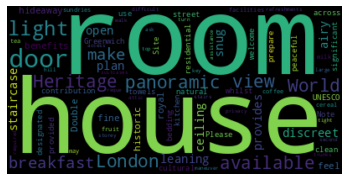

In [73]:
wordcloud = WordCloud().generate(description_2)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [75]:
train = train[['accommodates', 'bathrooms', 'bedrooms','beds', 'price','guests_included']]
target = np.array(train.price)
train = train.drop('price', axis=True)
test = test[['accommodates', 'bathrooms', 'bedrooms','beds','guests_included']]

In [54]:
target = np.array(target)

In [55]:
target

array([ 35.,  75., 120., ...,  89.,  80., 110.], dtype=float32)

# Model Benchmarking

## Linear Regression

In [56]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(train, target)


In [57]:
print(reg.score(train, target))


0.3688230712027004


In [58]:
predictions = reg.predict(test)
predictions = pd.Series(predictions, index=test.index, name='price')
predictions


listing_id
0FEMC4VA5U     73.209034
PQ2BYEO0QR     73.209034
3FP6WFHUBN     94.879159
GG0V2KDG90     60.433445
TZVVK4YSIO     93.339291
                 ...    
SCRJ69GZPK    243.018222
ILZN192SUC     80.432409
A44OQ7GPYY    108.992554
KZ742YLH4X     73.209034
YOCQ63ZYYD     73.209034
Name: price, Length: 29769, dtype: float64

In [59]:
predictions.to_csv('../predictions/sample_submission.csv')

# Conclusion and Outlook

There is always so much more you can do!